# examine latent space with and without similarity/consistency losses

In [1]:
import os
import pickle
import numpy as np
import torch

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
import umap.plot

/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
print("torch.cuda.device_count():",torch.cuda.device_count())

torch.cuda.device_count(): 0


/home/chhahn/.conda/envs/gqp/lib/python3.11/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


# load `SpenderQ` model

In [5]:
niter = 3
models0, _ = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter)
models1, _ = load_model('/tigress/chhahn/spender_qso/models/london.rebin.iter%i.simloss.pt' % niter)
models2, _ = load_model('/tigress/chhahn/spender_qso/models/london.rebin.iter%i.simconloss.pt' % niter)

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


# get latents
over 10 batches (~10k spectra) 

In [6]:
specs, norms, zreds = [], [], []
lats0, lats1, lats2 = [], [], []
for ibatch in range(10): 
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    
    specs.append(np.array(spec))
    norms.append(np.array(norm))
    zreds.append(np.array(z))
    
    with torch.no_grad():
        models0[0].eval()
        s0 = models0[0].encode(spec)
        
        models1[0].eval()
        s1 = models1[0].encode(spec)
        
        models2[0].eval()
        s2 = models2[0].encode(spec)
        
    lats0.append(np.array(s0))
    lats1.append(np.array(s1))
    lats2.append(np.array(s2))
    
specs = np.concatenate(specs)
norms = np.concatenate(norms)
zreds = np.concatenate(zreds)

lats0 = np.concatenate(lats0, axis=0)
lats1 = np.concatenate(lats1, axis=0)
lats2 = np.concatenate(lats2, axis=0)

# embed latents using UMAP

In [7]:
umapper0 = umap.UMAP().fit(np.array(lats0))
umapper1 = umap.UMAP().fit(np.array(lats1))
umapper2 = umap.UMAP().fit(np.array(lats2))

# check redshift dependence

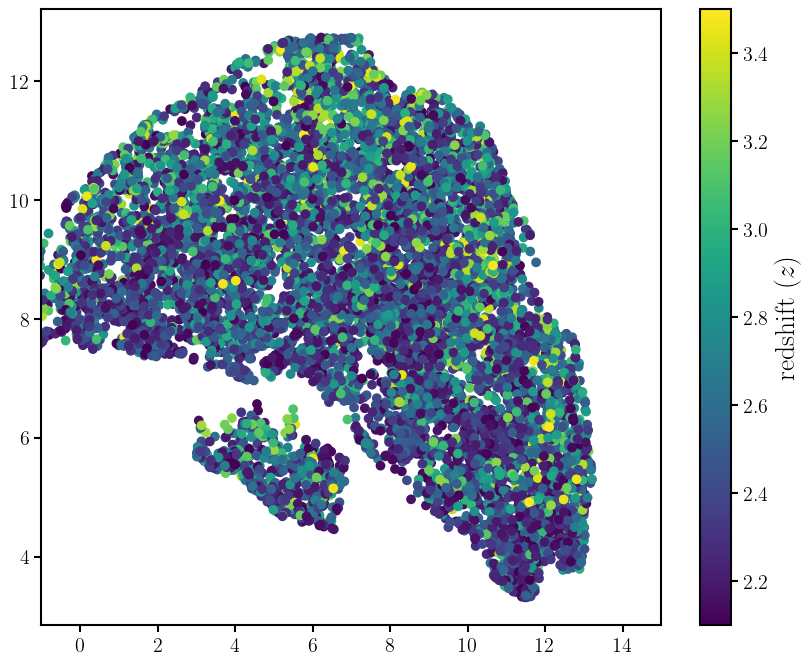

In [8]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper0.embedding_[:,0], 
                 umapper0.embedding_[:,1], c=np.array(zreds), 
                 cmap='viridis', vmin=2.1, vmax=3.5)

#sub.set_xticks([])
sub.set_xlim(-1, 15)
#sub.set_yticks([])
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

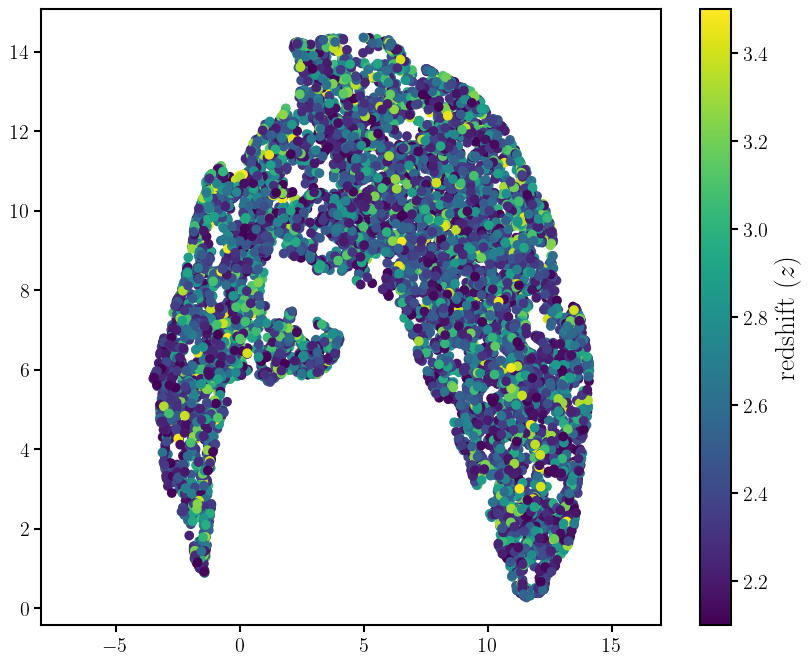

In [9]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper1.embedding_[:,0], 
                 umapper1.embedding_[:,1], c=np.array(zreds), 
                 cmap='viridis', vmin=2.1, vmax=3.5)

#sub.set_xticks([])
sub.set_xlim(-8, 17)
#sub.set_yticks([])
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

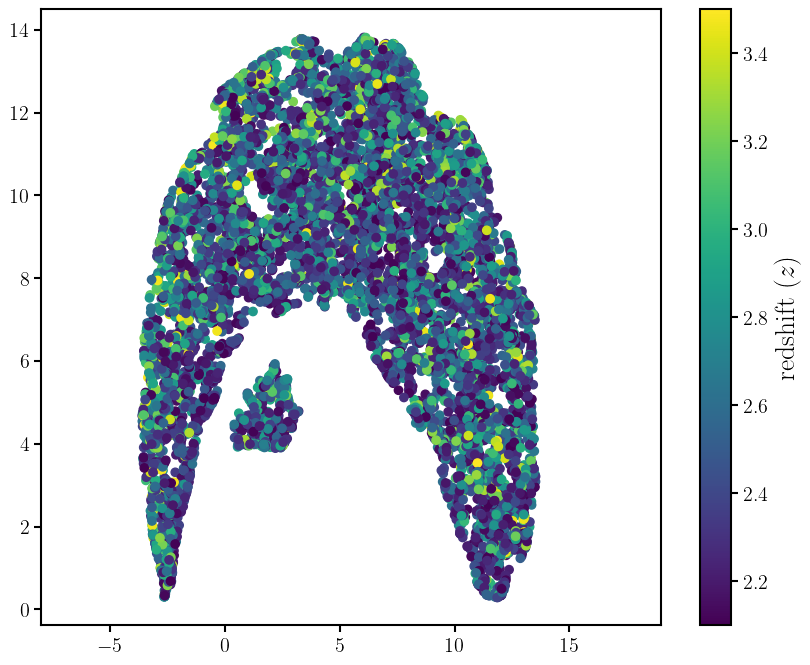

In [10]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper2.embedding_[:,0], 
                 umapper2.embedding_[:,1], c=np.array(zreds), 
                 cmap='viridis', vmin=2.1, vmax=3.5)

#sub.set_xticks([])
sub.set_xlim(-8, 19)
#sub.set_yticks([])
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

# check SNR dependence

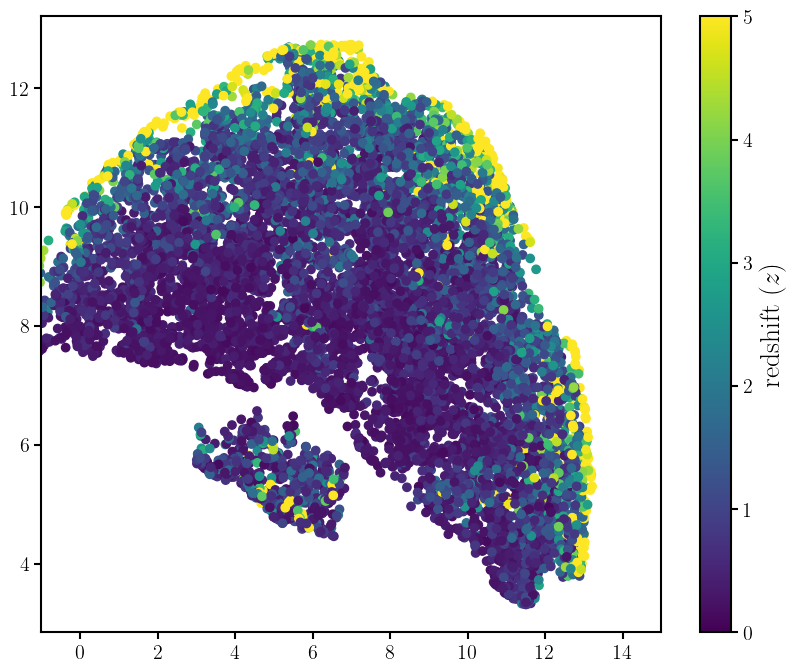

In [11]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper0.embedding_[:,0], 
                 umapper0.embedding_[:,1], c=np.array(norms), 
                 cmap='viridis', vmin=0., vmax=5.)

#sub.set_xticks([])
sub.set_xlim(-1, 15)
#sub.set_yticks([])
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

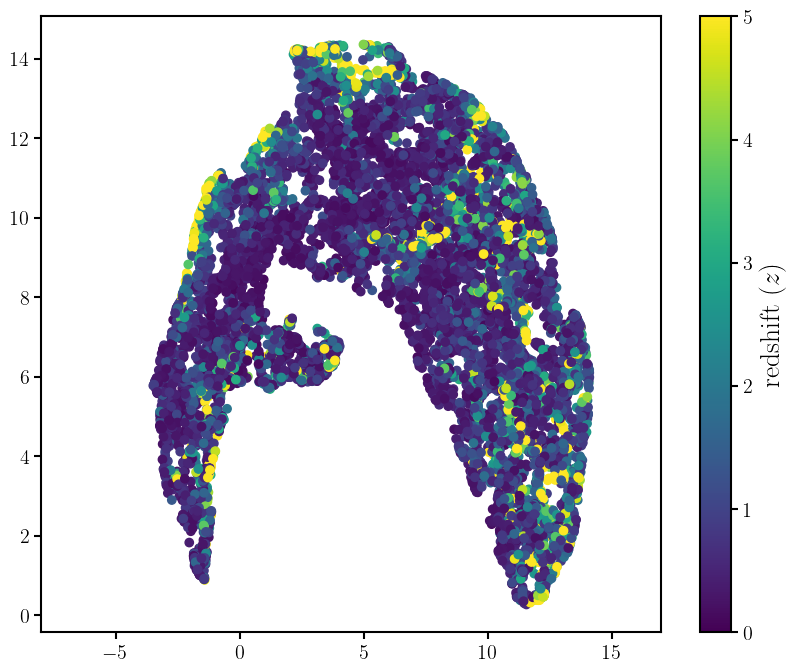

In [12]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper1.embedding_[:,0], 
                 umapper1.embedding_[:,1], c=np.array(norms), 
                 cmap='viridis', vmin=0., vmax=5.)

#sub.set_xticks([])
sub.set_xlim(-8, 17)
#sub.set_yticks([])
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

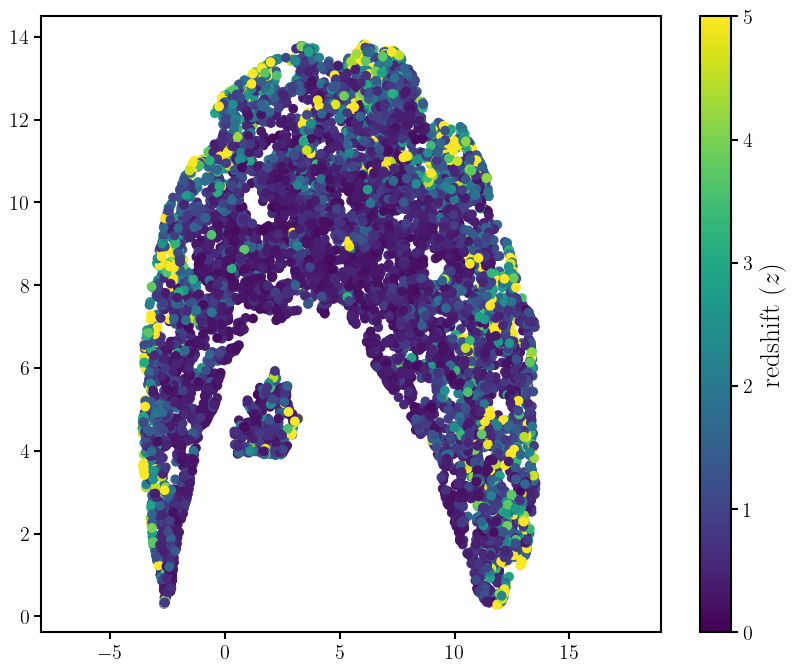

In [13]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper2.embedding_[:,0], 
                 umapper2.embedding_[:,1], c=np.array(norms), 
                 cmap='viridis', vmin=0, vmax=5.)

#sub.set_xticks([])
sub.set_xlim(-8, 19)
#sub.set_yticks([])
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

In [20]:
island2 = ((umapper2.embedding_[:,0] > 0) & (umapper2.embedding_[:,0] < 5) & 
           (umapper2.embedding_[:,1] < 6.))

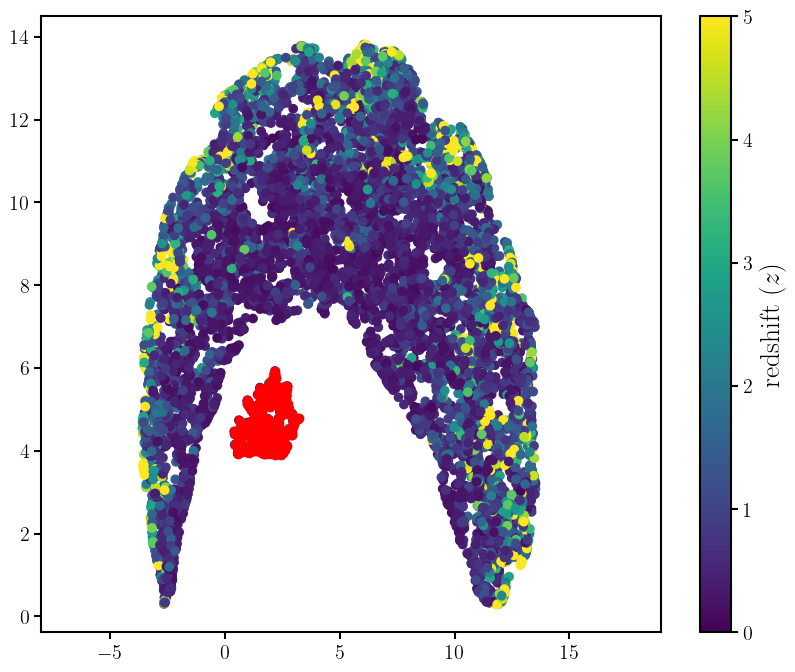

In [21]:
fig = plt.figure(figsize=(10,8))
sub = fig.add_subplot(111)
sc = sub.scatter(umapper2.embedding_[:,0], 
                 umapper2.embedding_[:,1], c=np.array(norms), 
                 cmap='viridis', vmin=0, vmax=5.)
sub.scatter(umapper2.embedding_[:,0][island2], 
                 umapper2.embedding_[:,1][island2], c='r')


#sub.set_xticks([])
sub.set_xlim(-8, 19)
#sub.set_yticks([])
cbar = fig.colorbar(sc)
cbar.set_label(label='redshift ($z$)', size=20)

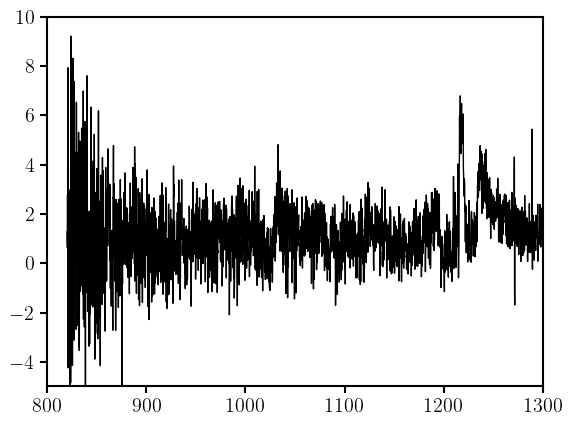

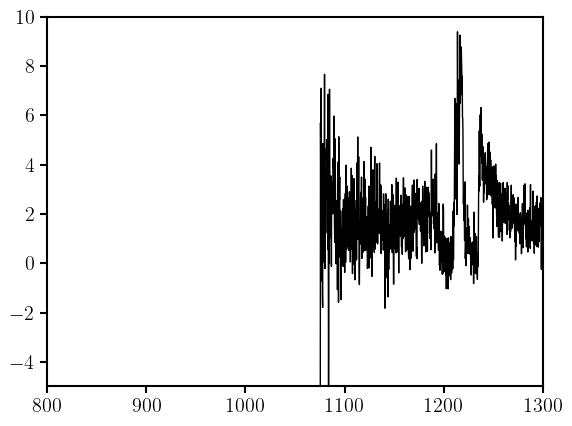

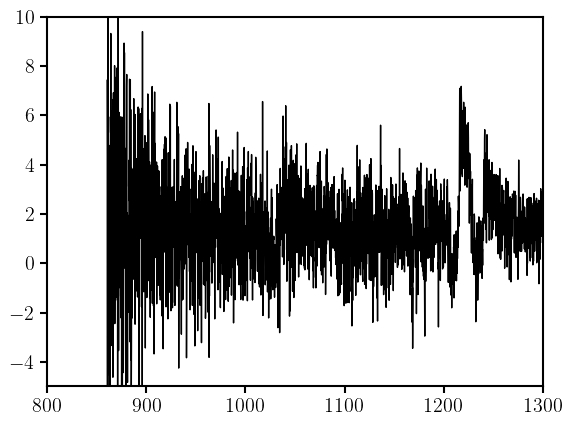

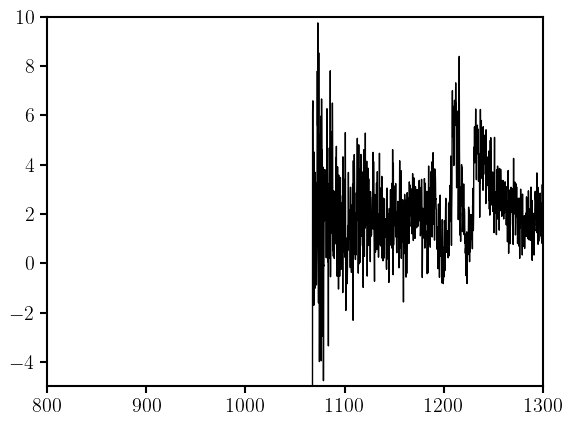

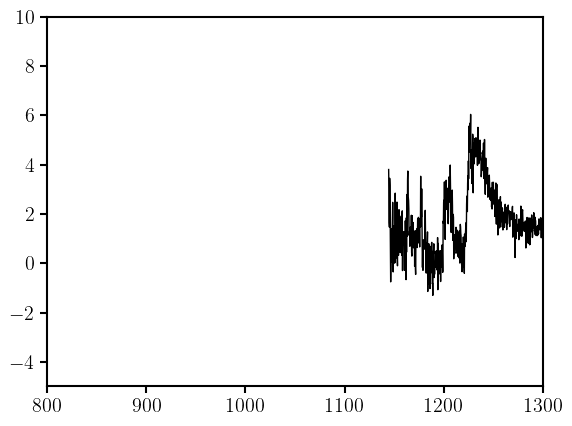

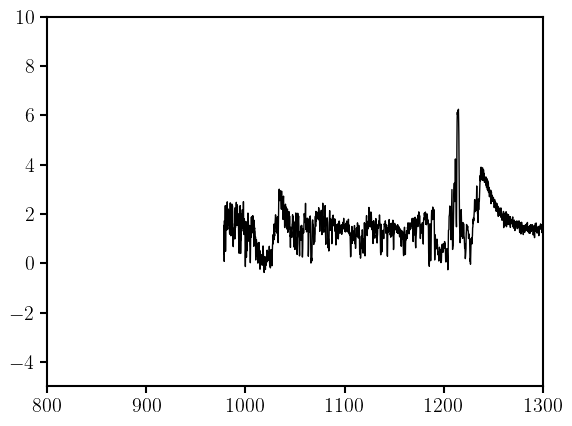

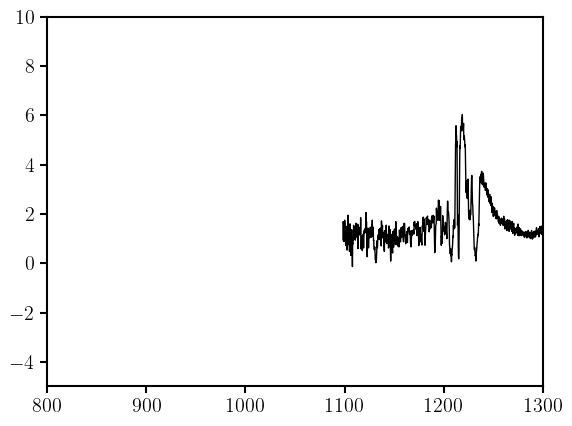

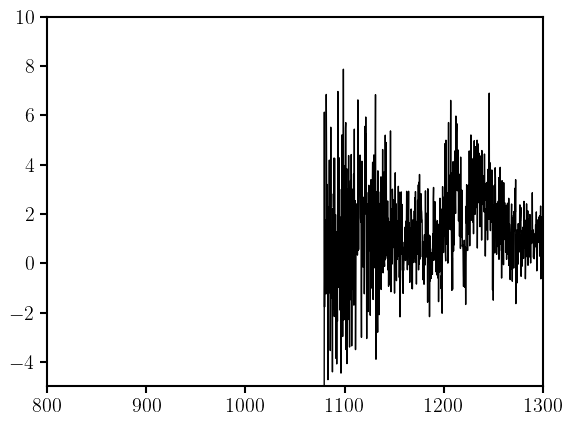

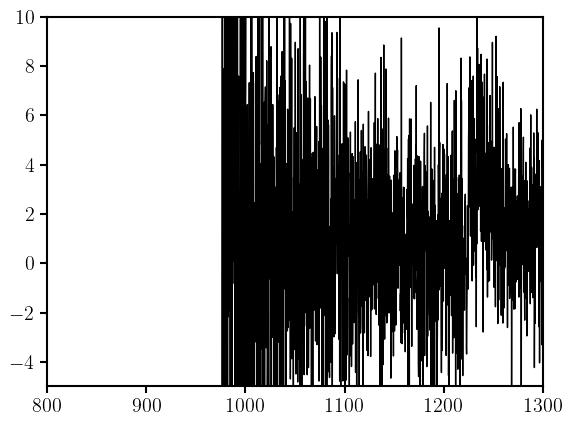

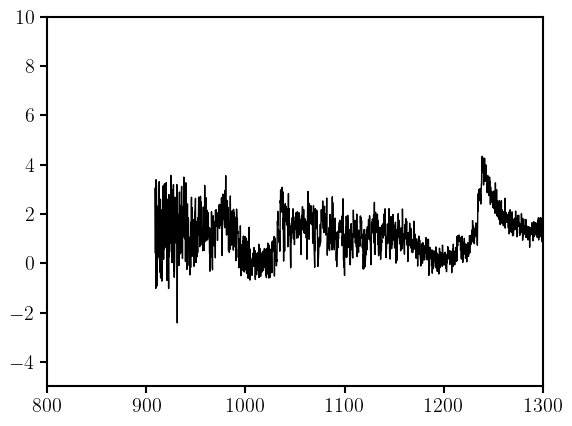

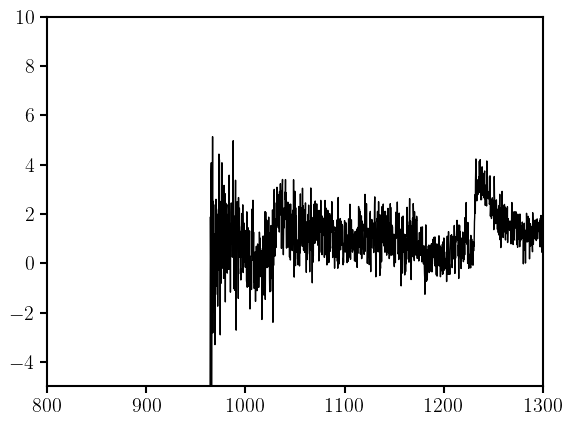

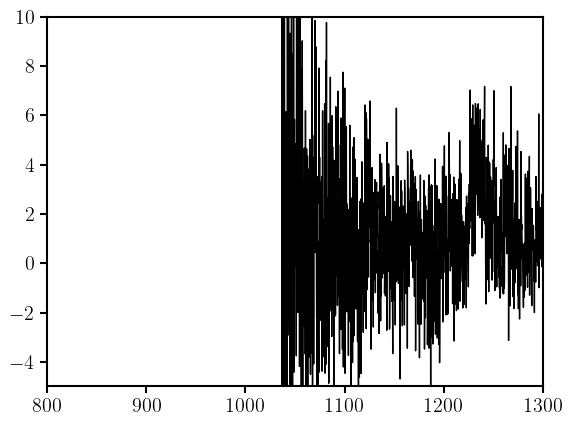

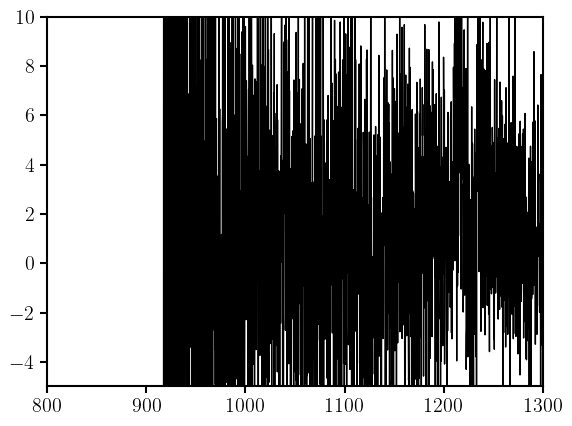

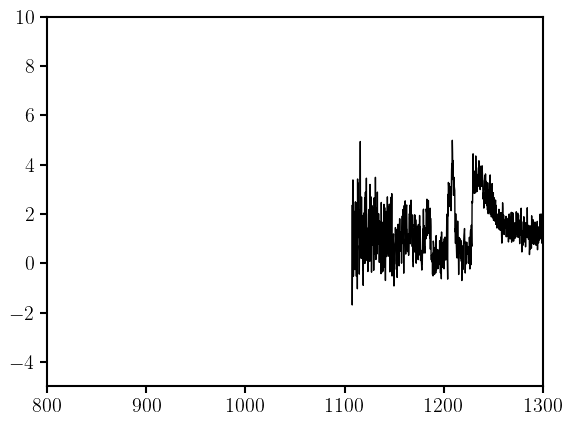

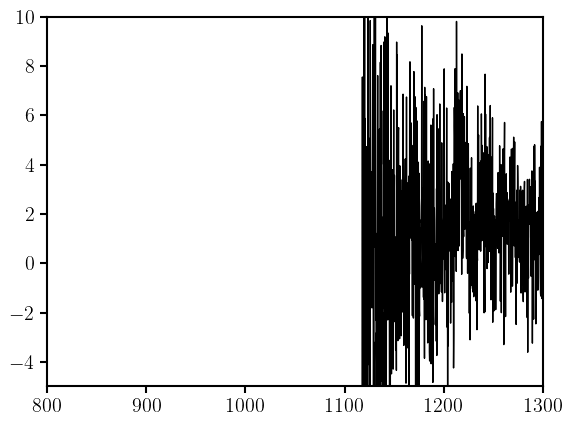

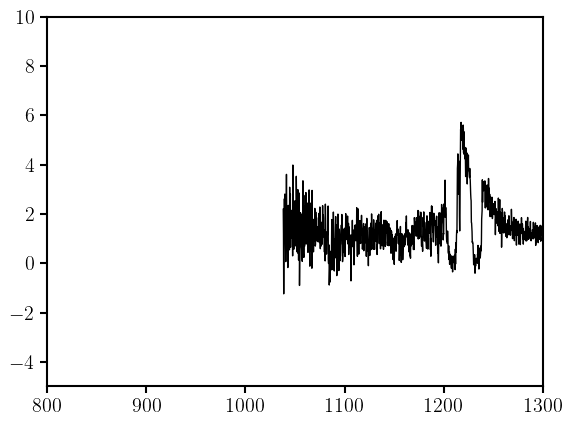

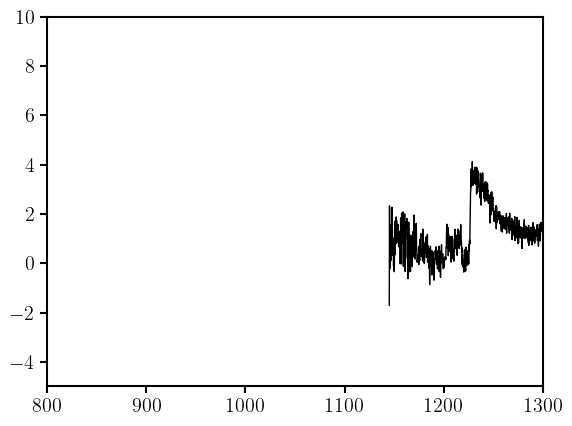

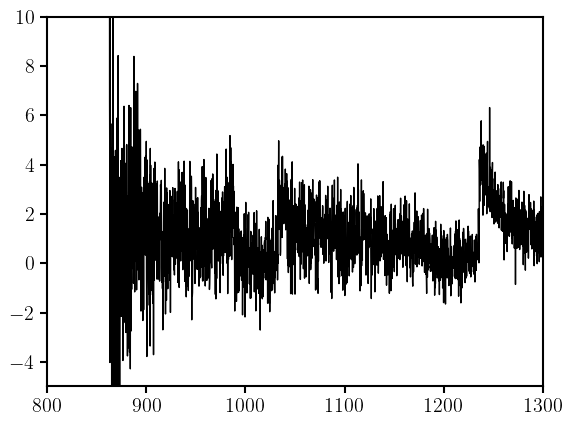

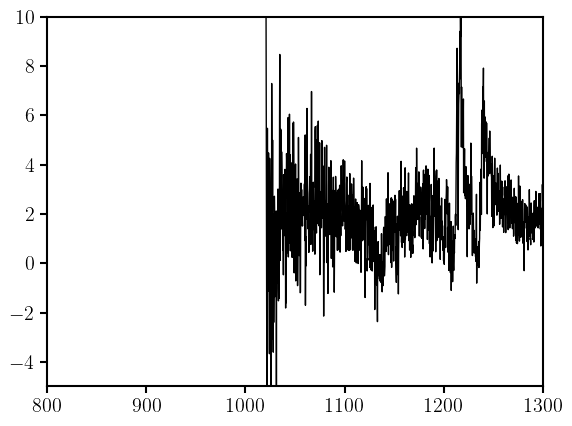

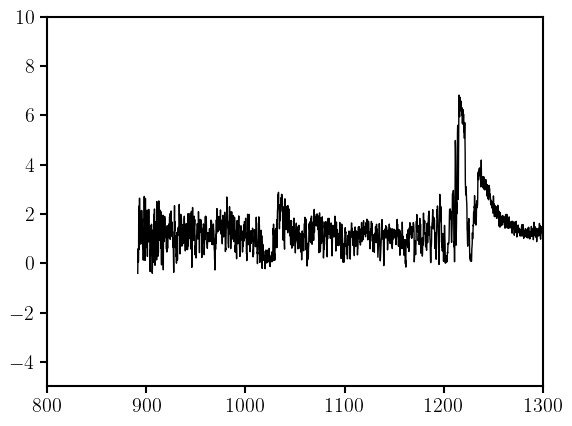

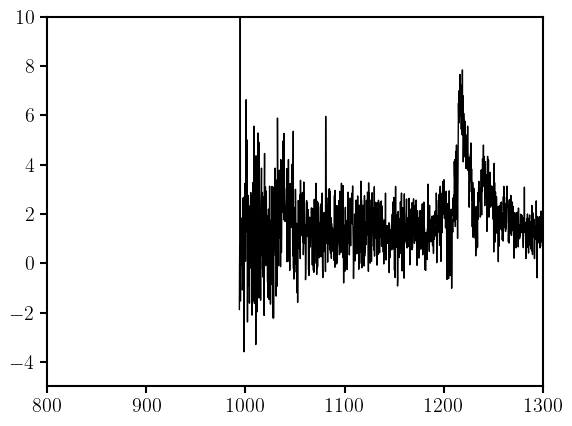

In [25]:
for i in np.arange(specs.shape[0])[island2][::20]: 
    plt.plot(models0[0].wave_obs/(1+zreds[i]), specs[i], c='k', lw=1)
    plt.xlim(800, 1300) 
    plt.ylim(-5, 10)
    plt.show()